## Data cleaning and analysis for Netflix using SQL 
Netflix, a leading global streaming platform, possesses a dataset containing information about its shows. However, the dataset requires cleaning and analysis to derive valuable insights for business decision-making. As a data analyst with SQL expertise, your objective is to perform data cleaning and analysis on the Netflix dataset to help the company gain insights into their content offerings.

Segment 1: Database - Tables, Columns, Relationships
-	Identify the tables in the dataset and their respective columns.
-	Determine the number of rows in each table within the schema.
-	Identify and handle any missing values in the dataset.


In [145]:
# Imports 
import numpy as np 
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [79]:
#Load the CSV file into a Pandas DataFrame:
csv_file = 'netflix_dataset.csv'
df = pd.read_csv(csv_file)

In [100]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['release_year'] = pd.to_datetime(df['release_year'], format='%Y')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   director      8790 non-null   object        
 4   country       8790 non-null   object        
 5   date_added    8790 non-null   datetime64[ns]
 6   release_year  8790 non-null   datetime64[ns]
 7   rating        8790 non-null   object        
 8   duration      8790 non-null   object        
 9   listed_in     8790 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 686.8+ KB


In [102]:
#Connect to a SQLite database and create a table:
db_file = 'netflix_data.sqlite'
conn = sqlite3.connect(db_file)

#Save the DataFrame to the SQLite database:
table_name = 'netflix_table'
df.to_sql(table_name, conn, if_exists='replace', index=False)
#Now, you have successfully loaded the CSV data into a SQLite database named 'netflix_data.db' 
#with a table named 'netflix_table'.

8790

In [134]:
conn = sqlite3.connect(db_file)

tables = pd.read_sql("""SELECT *
        FROM netflix_table
        ;""", conn)
print(tables.head())

  show_id     type                             title         director  \
0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
1      s3  TV Show                         Ganglands  Julien Leclercq   
2      s6  TV Show                     Midnight Mass    Mike Flanagan   
3     s14    Movie  Confessions of an Invisible Girl    Bruno Garotti   
4      s8    Movie                           Sankofa     Haile Gerima   

         country           date_added         release_year rating  duration  \
0  United States  2021-09-25 00:00:00  2020-01-01 00:00:00  PG-13    90 min   
1         France  2021-09-24 00:00:00  2021-01-01 00:00:00  TV-MA  1 Season   
2  United States  2021-09-24 00:00:00  2021-01-01 00:00:00  TV-MA  1 Season   
3         Brazil  2021-09-22 00:00:00  2021-01-01 00:00:00  TV-PG    91 min   
4  United States  2021-09-24 00:00:00  1993-01-01 00:00:00  TV-MA   125 min   

                                           listed_in  
0                              


# Segment 2: Content Analysis


In [117]:
#Analyse the distribution of content types (movies vs. TV shows) in the dataset.
conn = sqlite3.connect(db_file)
query1 = pd.read_sql("""
SELECT type, COUNT(*) AS count
FROM netflix_table
GROUP BY type;
""", conn)

query1

,type,count
0,Movie,6126
1,TV Show,2664


In [118]:
#Determine the top 10 countries with the highest number of productions on Netflix.
conn = sqlite3.connect(db_file)

query2 = pd.read_sql("""
SELECT country, COUNT(*) AS production_count
FROM netflix_table
WHERE country IS NOT 'Not Given'
GROUP BY country
ORDER BY production_count DESC
LIMIT 10;""", conn)

query2

,country,production_count
0,United States,3240
1,India,1057
2,United Kingdom,638
3,Pakistan,421
4,Canada,271
5,Japan,259
6,South Korea,214
7,France,213
8,Spain,182
9,Mexico,138


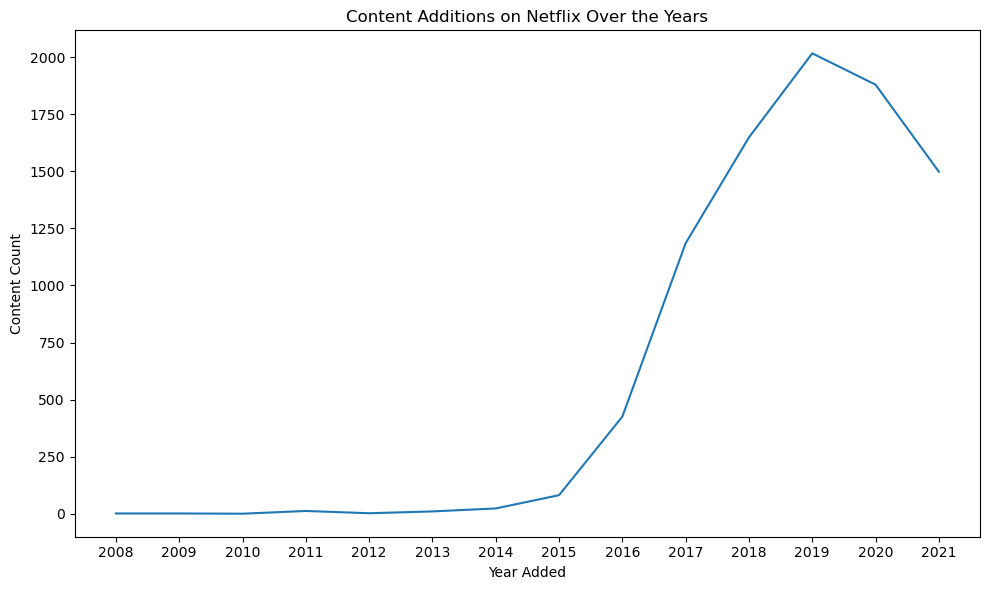

In [150]:
#Investigate the trend of content additions over the years.
conn = sqlite3.connect(db_file)

query3 = pd.read_sql("""
SELECT strftime('%Y', date_added) AS Year_added, COUNT(*) AS content_count
FROM netflix_table
WHERE date_added IS NOT NULL
GROUP BY strftime('%Y', date_added)
ORDER BY strftime('%Y', date_added);
""", conn)

query3

# Create the line chart using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year_added', y='content_count', data=query3)
plt.xlabel('Year Added')
plt.ylabel('Content Count')
plt.title('Content Additions on Netflix Over the Years')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [185]:
conn = sqlite3.connect(db_file)

#Create the netflix_movies table where type is 'Movie'
create_movies_table_query = """
    CREATE TABLE IF NOT EXISTS netflix_movies AS
    SELECT *
    FROM netflix_table
    WHERE type = 'Movie';
"""

# Execute the CREATE TABLE query
try:
    with conn:
        conn.execute(create_movies_table_query)
except Exception as e:
    print(f"Error occurred while creating the table: {e}")

# Commit the changes to the database
conn.commit()

#Remove 'min' suffix from the 'duration' column in the netflix_movies table
remove_min_suffix_query = """
    UPDATE netflix_movies
    SET duration = REPLACE(duration, ' min', '');
"""

# Execute the UPDATE query
try:
    with conn:
        conn.execute(remove_min_suffix_query)
except Exception as e:
    print(f"Error occurred while removing 'min' suffix: {e}")

# Commit the changes to the database
conn.commit()

# Convert the 'duration' column to minutes format in the netflix_movies table
convert_duration_query = """
    UPDATE netflix_movies
    SET duration = CAST(duration AS INTEGER);
"""

# Execute the UPDATE query
try:
    with conn:
        conn.execute(convert_duration_query)
except Exception as e:
    print(f"Error occurred while converting duration to minutes: {e}")

# Commit the changes to the database
conn.commit()


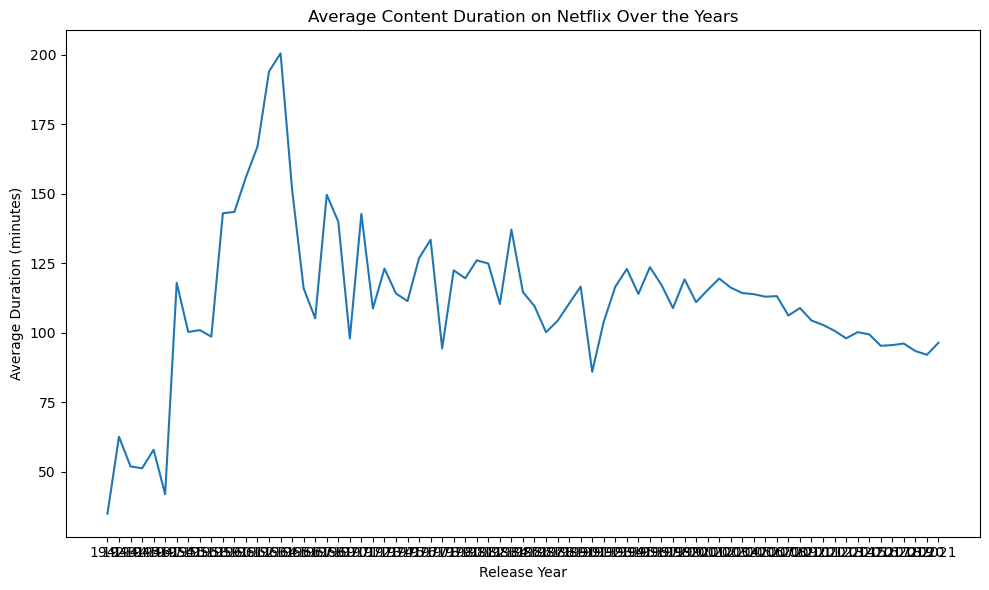

In [186]:
# Analyze the relationship between content duration and release year
conn = sqlite3.connect(db_file)
query4 = pd.read_sql("""
    SELECT strftime('%Y', release_year) as release_year, AVG(duration) AS average_duration
    FROM netflix_movies
    GROUP BY release_year
    ORDER BY release_year;
""", conn)

query4
# Create the line chart using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='release_year', y='average_duration', data=query4)
plt.xlabel('Release Year')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Content Duration on Netflix Over the Years')
plt.tight_layout()
plt.show()



In [120]:
#Identify the directors with the most content on Netflix.
conn = sqlite3.connect(db_file)

query5 = pd.read_sql("""
SELECT director, COUNT(*) AS directed
FROM netflix_table
WHERE director IS NOT 'Not Given'
GROUP BY director
ORDER BY COUNT(*) DESC;

""", conn)

query5

,director,directed
0,Rajiv Chilaka,20
1,"Raúl Campos, Jan Suter",18
2,Alastair Fothergill,18
3,Suhas Kadav,16
4,Marcus Raboy,16
...,...,...
4522,Aamir Khan,1
4523,Aamir Bashir,1
4524,Aadish Keluskar,1
4525,A. Salaam,1


# Segment 3: Genre and Category Analysis


In [ ]:
#Determine the unique genres and categories present in the dataset.

In [121]:
#Calculate the percentage of movies and TV shows in each genre.

In [122]:
#Identify the most popular genres/categories based on the number of productions.

In [123]:
#Calculate the cumulative sum of content duration within each genre.

# Segment 4: Release Date Analysis


In [129]:
#Determine the distribution of content releases by month and year.
conn = sqlite3.connect(db_file)

query6 = pd.read_sql("""
SELECT strftime('%Y', date_added) AS release_year, strftime('%m', date_added) AS release_month, COUNT(*) AS content_count
FROM netflix_table
WHERE date_added IS NOT NULL
GROUP BY release_year, release_month
ORDER BY release_year, release_month;
""", conn)

query6

,release_year,release_month,content_count
0,2011,10,2
1,2011,10,1
2,2011,10,3
3,2015,06,1
4,2015,10,34
...,...,...,...
518,2021,09,83
519,2021,09,94
520,2021,09,79
521,2021,09,90


In [ ]:
#Analyse the seasonal patterns in content releases.

In [131]:
#Identify the months and years with the highest number of releases.
conn = sqlite3.connect(db_file)

query8 = pd.read_sql("""
SELECT strftime('%Y', date_added) AS release_year, strftime('%m', date_added) AS release_month, COUNT(*) AS content_count
FROM netflix_table
WHERE date_added IS NOT NULL
GROUP BY release_year, release_month
ORDER BY content_count DESC;
""", conn)

query8

,release_year,release_month,content_count
0,2019,12,122
1,2019,11,109
2,2018,12,106
3,2020,10,106
4,2021,06,105
...,...,...,...
518,2021,07,1
519,2021,05,1
520,2019,02,1
521,2020,11,1


# Segment 5: Rating Analysis




In [ ]:
#Investigate the distribution of ratings across different genres.

In [ ]:
#Analyse the relationship between ratings and content duration.

# Segment 6: Co-occurrence Analysis



In [ ]:
#Identify the most common pairs of genres/categories that occur together in content.

In [237]:
#Analyse the relationship between genres/categories and content duration.
query9  = pd.read_sql("""
SELECT rating, AVG(duration) AS avg_duration
FROM netflix_movies
GROUP BY rating;
""", conn)
query9

,rating,avg_duration
0,G,90.268293
1,NC-17,125.000000
2,NR,94.533333
3,PG,98.282230
4,PG-13,108.330612
5,R,106.720201
6,TV-14,110.290820
7,TV-G,79.666667
8,TV-MA,95.889913
9,TV-PG,94.851852


# Segment 7: International Expansion Analysis





In [229]:
#Identify the countries where Netflix has expanded its content offerings.
conn = sqlite3.connect(db_file)

query12 = pd.read_sql("""
SELECT strftime('%Y', release_year) AS release_year, country, COUNT(*) AS content_count
FROM netflix_table
WHERE country IS NOT 'Not Given' AND release_year IS NOT NULL
GROUP BY release_year, country
ORDER BY release_year ;""", conn)
query12


,release_year,country,content_count
0,1925,Pakistan,1
1,1942,United States,2
2,1943,United States,3
3,1944,United States,3
4,1945,United States,4
...,...,...,...
859,2021,United Arab Emirates,2
860,2021,United Kingdom,29
861,2021,United States,168
862,2021,Uruguay,1


In [233]:
#Analyse the distribution of content types in different countries.

query13 = pd.read_sql("""SELECT country, type, COUNT(*) AS content_count
FROM netflix_table
WHERE country <> 'Not Given' 
GROUP BY country,type
ORDER BY content_count DESC
;""", conn)

query13


,country,type,content_count
0,United States,Movie,2395
1,India,Movie,976
2,United States,TV Show,845
3,United Kingdom,Movie,387
4,Pakistan,TV Show,350
...,...,...,...
131,Switzerland,TV Show,1
132,United Arab Emirates,TV Show,1
133,Uruguay,TV Show,1
134,West Germany,Movie,1


In [226]:
#Investigate the relationship between content duration and country of production.
query14 = pd.read_sql("""
SELECT country, AVG(duration) AS avg_duration, count(*) as movies_total
FROM netflix_table
WHERE type = 'Movie' AND country <> 'Not Given' 
GROUP BY country
ORDER BY COUNT(*) DESC;""", conn)
query14

,country,avg_duration,movies_total
0,United States,91.782463,2395
1,India,125.065574,976
2,United Kingdom,94.720930,387
3,Canada,87.657754,187
4,France,96.777027,148
...,...,...,...
73,Iran,123.000000,1
74,Guatemala,69.000000,1
75,Greece,106.000000,1
76,Croatia,157.000000,1


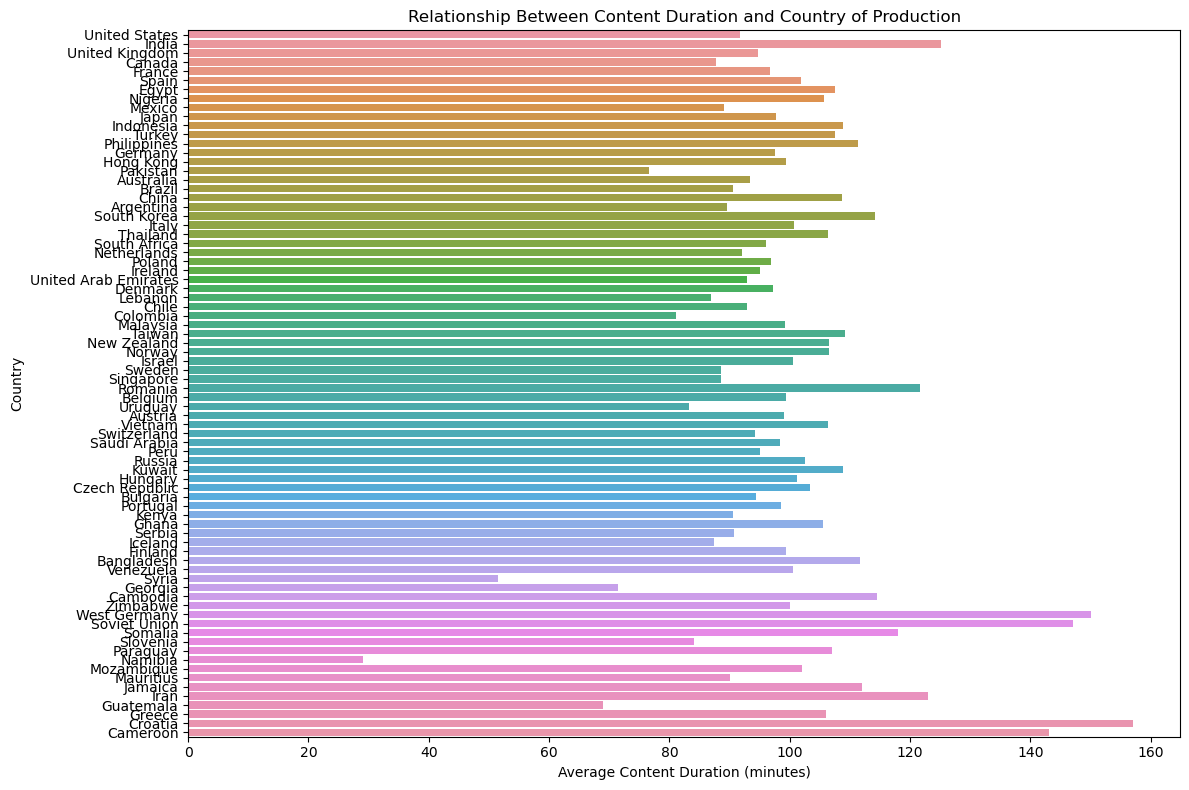

In [227]:
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_duration', y='country', data=query14)
plt.xlabel('Average Content Duration (minutes)')
plt.ylabel('Country')
plt.title('Relationship Between Content Duration and Country of Production')
plt.tight_layout()
plt.show()

# Segment 8: Recommendations for Content Strategy




#Based on the analysis, provide recommendations for the types of content Netflix should focus on producing.
it can be seen that the duration of the movies is close to 120 minutes in recent types

In [ ]:
#Identify potential areas for expansion and growth based on the analysis of the dataset.